# Cluster Exploration Notebook

In [1]:
# Import packages
import re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import Sci-Kit Learn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
import sqlite3

pd.set_option('display.max_columns', 500)

conn = sqlite3.connect('AI_SCOUT.db')

In [3]:
mod_data = pd.read_sql(
    """
    SELECT * FROM MODERN_NBA
    """, conn)
mod_data.head()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,youngtr01,Trae Young,2020,21,PG,ATL,-7.6,ATL,60,2120,65.1,35.3,29.3,59.5,9.2,4.2,1.2,4.8,7.1,-3.5,3.6,7.0,17.0,15.4,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8
1,huntede01,De'Andre Hunter,2020,22,SF,ATL,-7.6,ATL,63,2018,62.0,32.0,13.5,52.1,1.9,5.0,1.1,1.8,-2.5,-1.3,-3.8,-1.1,5.9,4.7,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1
2,huertke01,Kevin Huerter,2020,21,SG,ATL,-7.6,ATL,56,1760,54.1,31.4,13.6,53.6,4.2,4.5,1.5,1.7,-0.4,-2.4,-2.8,-0.1,8.0,8.1,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5
3,reddica01,Cam Reddish,2020,20,SF,ATL,-7.6,ATL,58,1551,47.6,26.7,13.7,50.0,2.0,4.9,2.0,2.2,-2.8,-0.1,-3.0,-0.2,5.9,5.0,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7
4,collijo01,John Collins,2020,22,PF,ATL,-7.6,ATL,41,1363,41.9,33.2,22.7,65.9,1.5,10.7,2.5,1.9,0.0,-0.3,-0.3,1.7,15.6,17.1,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8


In [60]:
data = data.set_index('name_common')
data.head()

AttributeError: 'NoneType' object has no attribute 'set_index'

In [4]:
data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id'], axis=1)

In [5]:
X = data.drop(['pos'], axis=1)
y = data['pos']

## Scale Data

In [58]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

## Dimensionality Reduction

In [59]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.49659353939300105


In [60]:
LDA = LinearDiscriminantAnalysis(n_components=2, 
                                 shrinkage='auto', 
                                 solver='eigen')


In [61]:
LDA_reduced_df = LDA.fit(X_scaled,y).transform(X_scaled)
LDA.score(X_scaled,y)

0.8858892921960072

In [10]:
def kmeans(reduced_data, n_clusters):
    """
    performs kmeans clustering and returns labels, centroids, inertia, and silhouette score
    """
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    kmeans = kmeans.fit(reduced_data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    sil_score = metrics.silhouette_score(reduced_data, kmeans.labels_, metric='euclidean')

    data_dictionary = {
        "labels": labels,
        "centroids": centroids,
        "inertia" : inertia,
        "silhouette_score": sil_score
    }

    return data_dictionary

In [77]:
def find_best_cluster(data,a,b):
    """
    plots and finds the best silhouette score for range(a,b)
    """
    scores = []
    for i in range(a,b):
        i_clusters = kmeans(data, i)
        sil_score_i = i_clusters['silhouette_score']
        scores.append(sil_score_i)
        print(i, sil_score_i)

    sns.set_context('poster', font_scale=1)
    plt.plot(range(a,b), scores)
    plt.title("""Measuring Silhouette Score to Find Best Cluster""")
    plt.show

In [12]:
def plot_kmeans_cluster(reduced_data, k_clusters, plot_title):
    kmeans = KMeans(init='k-means++', n_clusters=k_clusters, n_init=10)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(15,10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=10)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    plt.title(plot_title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

5 0.40394672247332647
6 0.3816784482610632
7 0.35774005790610003
8 0.3438939462733841
9 0.3530234168730909
10 0.35210747671593084
11 0.3418536049005271
12 0.3372771648466342
13 0.33829750007660814
14 0.3347218906167343
15 0.3346546601189806
16 0.33048129081614996
17 0.3297672759596519
18 0.33139096367150456
19 0.3209610000904572


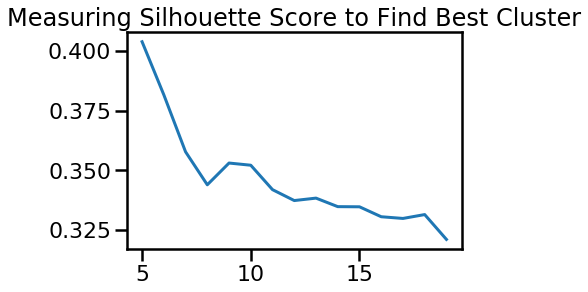

In [78]:
from sklearn import cluster, metrics, datasets
find_best_cluster(LDA_reduced_df,5,20)

In [79]:
k_means = kmeans(LDA_reduced_df, 9)

In [80]:
# Assign labels
data['Cluster'] = k_means['labels']
mod_data['Cluster'] = k_means['labels']

# Print silhouette score
print ("silhouette score:", k_means['silhouette_score'])

silhouette score: 0.3530234168730909


In [115]:
mod_data.to_sql('CLUSTERS', conn, if_exists='replace', index=False)

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/pandas/core/generic.py:2712: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [81]:
# Target labels
y = k_means['labels']
df = pd.DataFrame({'X1':LDA_reduced_df[:,0],
                   'X2':LDA_reduced_df[:,1], 
                   'labels':y})

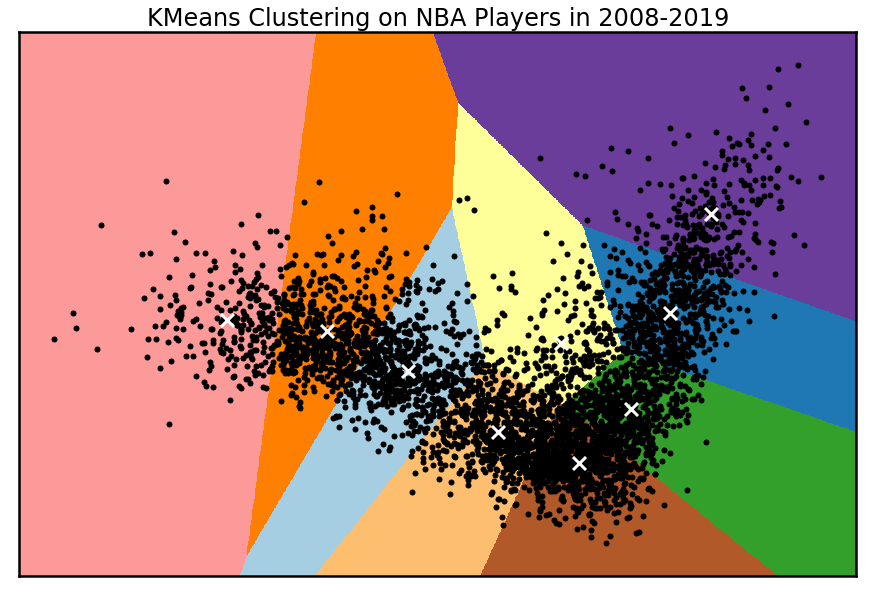

In [87]:
plot_kmeans_cluster(LDA_reduced_df, k_clusters=9, 
                    plot_title="""KMeans Clustering on NBA Players in 2008-2019""")

In [88]:
mod_data.loc[data['pos']=='C']

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Cluster
6,jonesda03,Damian Jones,2020,24,C,ATL,-7.6,ATL,55,887,27.2,16.1,12.1,71.2,1.4,8.1,2.6,1.1,-1.5,-2.6,-4.2,-0.7,8.3,10.2,11.4,5.6,11.5,8.9,16.2,12.5,1.4,3.8,137.7,11.7,113.5,70.4,22.2,73.8,5.1,47.2,8
8,lenal01,Alex Len,2020,26,C,ATL,-7.6,ATL,40,745,22.9,18.6,16.4,59.0,2.0,10.8,2.5,1.8,-2.4,1.6,-0.8,0.8,11.2,12.1,18.6,8.7,11.7,9.8,23.6,16.6,1.3,3.7,115.3,18.7,112.1,62.7,25.0,63.0,21.5,31.2,8
9,fernabr01,Bruno Fernando,2020,21,C,ATL,-7.6,ATL,56,713,21.9,12.7,11.8,54.2,2.4,9.7,1.7,2.1,-3.1,-0.7,-3.7,-0.4,7.3,7.2,15.3,9.9,15.9,10.0,20.0,15.0,1.2,2.0,107.3,16.2,114.2,60.5,13.5,56.9,18.6,25.6,8
15,theisda01,Daniel Theis,2020,27,C,BOS,6.2,BOS,58,1382,44.6,23.8,14.1,62.9,2.5,10.0,2.9,1.3,-0.3,1.9,1.6,3.0,10.9,13.0,14.7,9.9,10.1,10.2,19.2,14.7,1.2,5.0,130.1,15.5,104.8,63.1,32.1,76.4,21.2,27.7,8
19,kanteen01,Enes Kanter,2020,27,C,BOS,6.2,BOS,51,891,28.8,17.5,16.9,59.4,2.0,16.0,2.4,2.1,1.1,1.7,2.8,2.5,15.4,17.1,19.3,8.4,12.9,17.1,30.2,23.7,1.1,3.9,121.5,20.5,102.8,57.6,14.3,70.8,2.3,28.6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,okurme01,Mehmet Okur,2008,28,C,UTA,7.4,UTA,72,2390,60.6,33.2,16.9,55.6,2.3,9.0,1.4,1.7,0.4,0.4,0.8,4.4,10.8,11.1,19.6,9.0,9.9,6.8,21.5,14.2,1.2,1.0,113.6,18.8,106.6,47.5,38.8,80.4,35.0,27.3,1
4393,collija03,Jarron Collins,2008,29,C,UTA,7.4,UTA,70,702,17.8,10.0,6.5,51.5,2.0,6.4,0.9,1.2,-4.0,0.1,-3.9,-0.4,2.5,2.4,8.7,6.8,16.1,7.0,13.1,10.1,0.7,0.7,111.0,9.7,109.8,44.4,0.0,62.2,1.2,90.2,1
4400,haywobr01,Brendan Haywood,2008,28,C,WAS,-0.4,WAS,80,2228,56.0,27.9,15.3,58.2,1.3,10.4,3.0,2.0,-0.2,0.5,0.3,3.4,10.2,12.6,17.3,5.2,12.9,14.0,16.4,15.2,0.7,5.0,119.0,18.1,109.0,52.8,0.0,73.5,0.0,49.1,3
4404,songada01,Darius Songaila,2008,29,C,WAS,-0.4,WAS,80,1554,39.0,19.4,12.8,49.6,3.5,7.0,1.8,2.2,-3.0,0.7,-2.2,0.4,7.5,6.1,17.3,14.2,14.7,6.0,14.7,10.2,1.8,0.9,102.2,17.8,109.9,46.0,0.0,91.8,0.4,15.6,0


In [89]:
centers = mod_data.loc[data['pos']=='C']

In [90]:
centers['Cluster'].value_counts()

8    411
3    231
1    177
7     29
0     10
Name: Cluster, dtype: int64

In [91]:
point_guards = mod_data.loc[data['pos']=='PG']
point_guards['Cluster'].value_counts()

6    430
4    268
5    118
0     35
2     10
Name: Cluster, dtype: int64

In [92]:
s_guards = mod_data.loc[data['pos']=='SG']
s_guards['Cluster'].value_counts()

2    408
5    338
6     93
0     65
7     55
4      9
1      4
Name: Cluster, dtype: int64

In [93]:
p_forward = mod_data.loc[data['pos']=='PF']
p_forward['Cluster'].value_counts()

1    343
7    267
8    164
0     46
2     38
3     27
5      2
4      2
6      1
Name: Cluster, dtype: int64

In [114]:
s_forward = mod_data.loc[data['pos']=='SF']
s_forward['Cluster'].value_counts()

2    326
7    303
0     71
5     69
1     36
6     18
8      4
Name: Cluster, dtype: int64

In [113]:
mod_data.loc[mod_data['name_common']=='Nikola Jokic']

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Cluster
751,jokicni01,Nikola Jokic,2018,22,C,DEN,1.5,DEN,75,2443,61.4,32.6,21.1,60.3,7.0,12.2,2.3,3.2,5.2,0.3,5.5,10.3,17.3,17.3,24.2,29.6,15.5,9.0,27.9,18.5,1.8,2.1,120.7,25.7,107.2,53.8,39.6,85.0,27.7,31.0,1
1103,jokicni01,Nikola Jokic,2017,21,C,DEN,0.5,DEN,73,2038,51.6,27.9,21.9,64.0,6.5,12.9,2.1,3.1,6.4,0.9,7.3,10.6,17.7,18.1,23.5,28.8,15.2,11.6,27.2,19.5,1.5,2.1,125.7,24.9,109.4,62.8,32.4,82.5,16.3,26.7,8
1454,jokicni01,Nikola Jokic,2016,20,C,DEN,-3.2,DEN,80,1733,43.7,21.7,17.3,58.2,4.1,12.2,2.8,2.3,3.6,4.5,8.2,9.7,14.6,16.6,19.9,18.1,13.2,11.4,24.7,17.9,2.3,2.3,118.2,20.9,104.4,54.1,33.3,81.1,14.0,31.7,1


In [99]:
mod_data.loc[mod_data['name_common']=='Chris Paul']

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Cluster
215,paulch01,Chris Paul,2020,34,PG,OKC,2.5,OKC,63,2003,64.8,31.8,20.3,60.9,7.8,5.7,2.0,2.5,6.2,-2.1,4.0,6.9,15.7,16.0,23.2,33.4,13.0,1.2,15.5,8.6,2.4,0.4,121.1,24.3,108.5,55.7,36.2,90.0,34.7,31.1,6
441,paulch01,Chris Paul,2019,33,PG,HOU,4.8,HOU,58,1857,46.8,32.0,17.9,56.0,9.4,5.3,2.6,3.0,3.6,0.9,4.4,6.8,13.8,13.8,22.5,39.3,15.8,2.1,13.9,7.9,3.0,0.8,118.1,24.6,109.0,47.9,35.8,86.2,49.3,28.2,4
791,paulch01,Chris Paul,2018,32,PG,HOU,8.7,HOU,58,1847,46.7,31.8,21.6,60.4,9.1,6.3,2.2,2.6,7.6,1.1,8.6,10.6,17.0,17.8,24.5,40.9,12.5,2.3,16.7,9.5,2.6,0.6,125.9,26.1,105.0,53.2,38.0,91.9,47.5,27.7,4
1164,paulch01,Chris Paul,2017,31,PG,LAC,4.5,LAC,61,1921,48.6,31.5,21.5,61.4,11.0,5.9,2.5,2.9,7.5,1.4,8.9,11.4,18.2,19.7,24.4,46.8,14.0,2.4,15.0,8.8,3.1,0.3,126.0,26.8,106.0,51.8,41.1,89.2,38.5,33.1,4
1512,paulch01,Chris Paul,2016,30,PG,LAC,4.4,LAC,74,2420,61.0,32.7,22.5,57.5,11.5,4.8,2.6,3.0,7.5,1.6,9.0,14.6,18.9,20.0,27.1,52.7,13.4,1.8,12.0,7.0,3.1,0.4,119.2,29.4,102.9,50.1,37.1,89.6,29.5,29.4,4
1863,paulch01,Chris Paul,2015,29,PG,LAC,6.9,LAC,82,2857,72.4,34.8,20.8,59.6,11.2,5.0,2.3,2.5,8.5,2.1,10.6,19.4,18.2,19.7,23.7,47.4,12.7,2.1,12.5,7.4,2.8,0.4,125.6,25.9,104.9,52.3,39.8,90.0,29.8,27.4,4
2207,paulch01,Chris Paul,2014,28,PG,LAC,7.2,LAC,62,2171,55.0,35.0,20.5,58.0,11.5,4.6,2.7,2.5,7.1,3.9,11.0,15.3,18.2,19.8,23.7,48.9,12.4,2.0,11.4,6.9,3.5,0.1,124.6,26.0,103.2,49.8,36.8,85.5,24.4,39.7,4
2555,paulch01,Chris Paul,2013,27,PG,LAC,7.1,LAC,70,2335,59.2,33.4,20.1,59.4,11.5,4.4,3.0,2.7,7.9,1.4,9.3,14.3,18.9,21.0,22.6,46.5,13.7,2.8,10.5,6.7,3.8,0.4,127.0,25.0,102.4,53.8,32.8,88.5,27.1,37.7,4
2892,paulch01,Chris Paul,2012,26,PG,LAC,2.8,LAC,60,2181,68.3,36.4,22.0,58.1,10.1,3.9,2.9,2.3,8.1,1.9,10.0,14.2,19.1,21.7,24.3,43.8,10.8,2.3,9.4,5.8,3.8,0.2,126.1,25.8,104.5,51.1,37.1,86.1,23.9,33.9,4
3302,paulch01,Chris Paul,2011,25,PG,NOH,1.0,NOH,80,2880,72.6,36.0,17.9,57.8,11.0,4.6,2.7,2.5,6.4,2.5,8.9,17.1,17.6,20.1,21.1,45.8,13.9,1.6,12.3,6.9,3.5,0.1,122.2,23.3,103.1,48.2,38.8,87.8,19.7,41.4,4


In [76]:
p_forward = mod_data.loc[data['pos']=='PF']
p_forward['Cluster'].value_counts()

1    331
7    273
6    187
2     34
3     33
4     18
5     12
0      2
Name: Cluster, dtype: int64

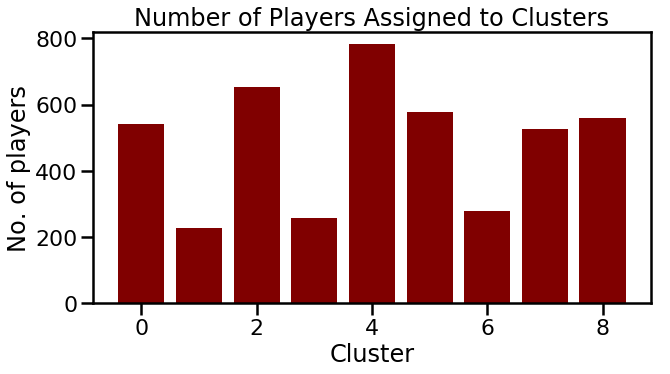

In [102]:
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(mod_data['Cluster'].unique(), mod_data['Cluster'].value_counts(), color ='maroon') 
  
plt.xlabel("Cluster") 
plt.ylabel("No. of players") 
plt.title("Number of Players Assigned to Clusters") 
plt.show() 

In [53]:
mask = (data['Cluster'] == 7)
c7 = list(data[mask].index)

In [34]:
c7[4]

118

In [54]:
c7=mod_data.iloc[c7,:]

In [55]:
c7.head()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Cluster
0,youngtr01,Trae Young,2020,21,PG,ATL,-7.6,ATL,60,2120,65.1,35.3,29.3,59.5,9.2,4.2,1.2,4.8,7.1,-3.5,3.6,7.0,17.0,15.4,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8,7
45,grahade01,Devonte' Graham,2020,24,PG,CHO,-7.0,CHA,63,2211,70.2,35.1,19.5,53.7,8.0,3.6,1.3,3.1,3.0,-1.5,1.5,4.8,11.0,10.9,24.8,35.3,14.5,2.0,8.7,5.2,1.4,0.6,109.0,25.7,115.8,39.7,37.3,82.0,60.7,24.2,7
62,dellama01,Matthew Dellavedova,2020,29,PG,CLE,-7.9,CLE,57,821,26.1,14.4,7.9,46.3,8.0,3.3,1.0,2.6,-1.7,2.6,0.9,1.5,5.6,4.2,13.0,29.0,23.6,2.4,7.8,5.1,1.2,0.2,103.0,15.3,118.6,48.8,23.1,86.5,52.0,21.1,7
91,rosede01,Derrick Rose,2020,31,PG,DET,-3.6,DET,50,1298,40.7,26.0,25.7,55.5,7.9,3.4,1.6,3.6,2.6,-2.2,0.4,2.1,14.8,12.9,31.6,40.5,13.4,2.3,8.3,5.3,1.5,1.0,109.3,31.9,115.2,53.5,30.6,87.1,19.5,18.5,7
118,brogdma01,Malcolm Brogdon,2020,27,PG,IND,2.0,IND,48,1472,46.9,30.7,19.5,53.7,8.5,5.6,1.0,2.9,0.7,0.4,1.1,2.9,13.2,11.9,25.2,34.5,13.6,3.0,13.8,8.5,1.1,0.5,110.4,26.6,110.9,49.1,31.3,89.5,29.6,24.6,7


In [48]:
def feature_importance(cluster_data, league_data):
    """
    takes reduced data,
    performs Principal Component Analysis,
    returns feature importance dataframe
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)

    pca = PCA(n_components=2)
    PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

    features = pd.DataFrame(zip(cluster_data.columns, pca.components_[0], np.mean(cluster_data), np.mean(league_data)),
        columns=['Feature', 'Importance', 'Cluster Average', 'League Average']).sort_values('Importance', ascending=False).head(10)

    return features

In [112]:
mask = (data['Cluster'] == 8)
c8 = list(data[mask].index)
c8 = mod_data.iloc[c8,:]
cluster_data = c8.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)
league_data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.301756,10.192573,9.413770
1,AWS%,0.280398,10.940587,9.525522
2,Raptor WAR,0.257209,1.708290,2.342015
3,Raptor O,0.253346,-1.594128,-0.437636
4,P/36,0.251126,14.821416,15.303426
5,MPG,0.245677,21.024352,23.706443
6,Raptor+/-,0.238368,-0.978756,-0.499660
7,MP%,0.234117,35.509499,40.354628
8,Min,0.230233,1370.072539,1551.274728
9,%Pos,0.226773,18.567530,19.028335


In [49]:
cluster_data = c7.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)
league_data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.275623,11.602518,9.413770
1,AWS%,0.267554,10.751799,9.525522
2,Raptor WAR,0.257350,3.674820,2.342015
3,Raptor+/-,0.254816,0.628417,-0.499660
4,Raptor O,0.250060,1.230576,-0.437636
5,AST%,0.231623,35.671223,13.661025
6,MPG,0.223624,26.740288,23.706443
7,MP%,0.221616,44.620144,40.354628
8,Min,0.217190,1713.115108,1551.274728
9,P/36,0.207904,16.000719,15.303426


In [104]:
mask = (data['Cluster'] == 6)
c6 = list(data[mask].index)
c6=mod_data.iloc[c6,:]
cluster_data = c6.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)
league_data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.279737,9.617343,9.413770
1,AWS%,0.272511,8.945756,9.525522
2,Raptor O,0.265800,0.248524,-0.437636
3,Raptor WAR,0.258335,2.670480,2.342015
4,Raptor+/-,0.252587,-0.279151,-0.499660
5,P/36,0.238819,15.856458,15.303426
6,AST%,0.231024,24.798339,13.661025
7,MPG,0.224376,24.675461,23.706443
8,MP%,0.220642,41.487638,40.354628
9,Min,0.218683,1596.431734,1551.274728


In [105]:
mask = (data['Cluster'] == 5)
c5 = list(data[mask].index)
c5=mod_data.iloc[c5,:]
cluster_data = c5.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)
league_data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.282300,8.604554,9.413770
1,AWS%,0.270914,8.345161,9.525522
2,Raptor O,0.263853,0.265655,-0.437636
3,Raptor WAR,0.260686,2.605123,2.342015
4,Raptor+/-,0.249195,-0.431499,-0.499660
5,AST%,0.238684,15.847818,13.661025
6,P/36,0.234485,16.270588,15.303426
7,MP%,0.228670,43.146110,40.354628
8,Min,0.228045,1666.081594,1551.274728
9,MPG,0.222205,25.139469,23.706443


In [107]:
mask = (data['Cluster'] == 4)
c4 = list(data[mask].index)
c4=mod_data.iloc[c4,:]
cluster_data = c4.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)
league_data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.276982,11.715412,9.413770
1,AWS%,0.269356,10.852330,9.525522
2,Raptor WAR,0.257848,3.746595,2.342015
3,Raptor+/-,0.255552,0.684229,-0.499660
4,Raptor O,0.252801,1.294982,-0.437636
5,AST%,0.231221,35.874552,13.661025
6,MPG,0.223379,27.000717,23.706443
7,MP%,0.221471,45.166667,40.354628
8,Min,0.215676,1730.254480,1551.274728
9,P/36,0.210652,16.116487,15.303426


In [108]:
mask = (data['Cluster'] == 3)
c3 = list(data[mask].index)
c3=mod_data.iloc[c3,:]
cluster_data = c3.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)
league_data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.317090,11.672093,9.413770
1,AWS%,0.301959,13.517054,9.525522
2,Raptor WAR,0.277506,2.639922,2.342015
3,Raptor+/-,0.263373,0.276744,-0.499660
4,MP%,0.242967,38.210853,40.354628
5,Raptor O,0.241835,-1.155426,-0.437636
6,MPG,0.241325,22.034109,23.706443
7,Min,0.235000,1471.841085,1551.274728
8,P/36,0.225796,14.338372,15.303426
9,TRB%,0.223444,19.170155,10.058575


In [109]:
mask = (data['Cluster'] == 2)
c2 = list(data[mask].index)
c2 = mod_data.iloc[c2,:]
cluster_data = c2.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)
league_data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.292414,7.621995,9.413770
1,AWS%,0.279556,7.907417,9.525522
2,Raptor WAR,0.270064,2.100639,2.342015
3,Raptor O,0.257378,-0.228772,-0.437636
4,Raptor+/-,0.256211,-0.668926,-0.499660
5,P/36,0.236815,14.753964,15.303426
6,MPG,0.231883,23.861637,23.706443
7,MP%,0.230532,40.776343,40.354628
8,Min,0.228130,1562.625320,1551.274728
9,AST%,0.219618,8.864450,13.661025


In [110]:
mask = (data['Cluster'] == 1)
c1 = list(data[mask].index)
c1 = mod_data.iloc[c1,:]
cluster_data = c1.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)
league_data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.289201,9.988393,9.413770
1,AWS%,0.277379,10.154643,9.525522
2,Raptor WAR,0.263059,2.069107,2.342015
3,Raptor O,0.254674,-1.214107,-0.437636
4,Raptor+/-,0.253034,-0.875000,-0.499660
5,MPG,0.247338,23.024464,23.706443
6,MP%,0.244569,39.557321,40.354628
7,Min,0.242982,1519.712500,1551.274728
8,P/36,0.233762,15.359286,15.303426
9,AST%,0.214630,9.454643,13.661025


In [111]:
mask = (data['Cluster'] == 0)
c0 = list(data[mask].index)
c0 = mod_data.iloc[c0,:]
cluster_data = c1.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)
league_data = mod_data.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id', 'pos'], axis=1)

feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1)

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.289201,9.988393,9.413770
1,AWS%,0.277379,10.154643,9.525522
2,Raptor WAR,0.263059,2.069107,2.342015
3,Raptor O,0.254674,-1.214107,-0.437636
4,Raptor+/-,0.253034,-0.875000,-0.499660
5,MPG,0.247338,23.024464,23.706443
6,MP%,0.244569,39.557321,40.354628
7,Min,0.242982,1519.712500,1551.274728
8,P/36,0.233762,15.359286,15.303426
9,AST%,0.214630,9.454643,13.661025


In [118]:
pd.read_sql(
    """
    SELECT * FROM CLUSTERS
    WHERE (pos='C' AND Cluster='0')
    ORDER BY "Raptor WAR" DESC
    LIMIT 15;
    """, conn)

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Cluster
0,jokicni01,Nikola Joki?,2019,23,C,DEN,4.0,DEN,80,2504,63.5,31.3,23.6,58.9,8.5,12.7,2.4,3.6,5.6,1.8,7.4,13.0,19.2,19.0,27.4,37.0,15.4,9.8,27.6,18.7,2.1,1.9,119.0,29.4,104.7,56.9,30.7,82.1,22.4,29.2,0
1,jokicni01,Nikola Joki?,2020,24,C,DEN,3.0,DEN,65,2101,66.7,32.3,23.1,60.4,7.9,11.7,2.1,3.6,4.0,1.0,5.0,8.3,18.2,17.6,26.6,34.3,15.7,8.2,26.9,17.6,1.8,1.9,118.8,28.2,106.3,59.4,31.4,81.3,23.3,27.7,0
2,gasolma01,Marc Gasol,2017,32,C,MEM,0.5,MEM,74,2531,63.6,34.2,22.3,55.4,5.2,7.2,2.6,2.6,0.9,1.6,2.5,6.7,16.0,15.5,26.4,24.8,11.3,2.6,18.8,10.5,1.4,3.7,110.7,26.1,105.9,48.0,38.8,83.7,23.1,28.6,0
3,horfoal01,Al Horford,2017,30,C,BOS,2.7,BOS,68,2193,55.5,32.3,16.1,55.3,5.7,7.9,2.3,2.0,0.7,0.3,1.0,4.1,13.0,13.2,19.7,24.4,11.8,4.9,18.6,11.8,1.2,3.2,113.8,20.5,107.3,52.4,35.5,80.0,30.2,16.9,0
4,horfoal01,Al Horford,2020,33,C,PHI,2.2,PHI,60,1848,58.9,30.8,14.2,52.6,4.8,8.1,2.1,1.3,0.4,1.0,1.4,3.9,11.5,12.4,17.6,19.2,8.7,5.5,19.1,12.3,1.4,2.5,114.4,17.9,107.6,51.3,33.7,75.3,40.4,11.2,0
5,westda01,David West,2017,36,C,GSW,11.6,GSW,68,854,21.6,12.6,13.4,57.1,6.4,8.6,3.8,3.3,-1.8,5.0,3.3,2.6,11.1,10.6,17.9,24.1,22.0,6.5,18.8,13.0,2.4,4.4,109.0,19.6,100.3,54.1,37.5,76.8,3.2,22.2,0
6,gasolma01,Marc Gasol,2020,35,C,TOR,6.4,TOR,36,990,32.0,27.5,9.9,54.6,4.5,8.2,2.2,1.6,-1.2,3.1,1.9,2.3,9.3,9.4,12.7,16.9,14.6,3.2,20.8,12.2,1.3,3.2,112.5,13.5,103.7,44.0,40.2,72.2,53.8,15.3,0
7,millebr01,Brad Miller,2011,34,C,HOU,2.3,HOU,60,1015,25.5,16.9,14.4,56.6,5.5,8.4,1.8,2.0,0.2,0.7,1.0,1.9,11.7,12.0,17.0,21.4,13.8,4.9,19.9,12.4,1.4,1.4,117.0,17.9,107.7,48.7,37.4,83.0,36.1,31.8,0
8,songada01,Darius Songaila,2008,29,C,WAS,-0.4,WAS,80,1554,39.0,19.4,12.8,49.6,3.5,7.0,1.8,2.2,-3.0,0.7,-2.2,0.4,7.5,6.1,17.3,14.2,14.7,6.0,14.7,10.2,1.8,0.9,102.2,17.8,109.9,46.0,0.0,91.8,0.4,15.6,0
9,kaminfr01,Frank Kaminsky,2017,23,C,CHO,0.2,CHA,75,1954,49.3,26.1,16.8,50.2,3.1,6.5,1.5,1.5,-1.1,-1.7,-2.8,-0.1,8.7,8.2,21.8,13.5,8.0,3.2,15.8,9.5,1.2,1.5,101.8,21.2,109.5,45.5,32.8,75.6,44.1,19.5,0


In [120]:
pd.read_sql(
    """
    SELECT * FROM CLUSTERS
    WHERE Cluster='0'
    ORDER BY "Raptor WAR" DESC
    LIMIT 15;
    """, conn)

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Cluster
0,jamesle01,LeBron James,2009,24,SF,CLE,10.0,CLE,81,3054,77.2,37.7,30.6,59.1,7.8,8.1,3.1,3.2,8.7,3.3,11.9,22.8,23.1,24.8,33.8,38.0,11.0,4.3,19.0,11.9,2.4,2.4,121.7,34.2,99.0,53.5,34.4,78.0,23.8,47.2,0
1,jamesle01,LeBron James,2013,28,PF,MIA,8.6,MIA,76,2877,72.4,37.9,28.1,64.0,7.6,8.4,2.7,3.1,8.8,1.1,9.9,18.4,22.7,24.1,30.2,36.4,12.4,4.4,20.8,13.1,2.4,1.9,124.6,30.5,100.9,60.2,40.6,75.3,18.8,39.5,0
2,greendr01,Draymond Green,2016,25,PF,GSW,10.7,GSW,81,2808,70.6,34.7,14.6,58.7,7.7,9.9,3.0,3.3,4.2,5.2,9.4,17.8,13.9,13.7,18.8,29.0,21.2,5.5,23.0,14.7,2.0,3.0,114.6,20.9,99.8,53.7,38.8,69.6,31.5,40.2,0
3,jamesle01,LeBron James,2008,23,SF,CLE,-0.4,CLE,75,3027,76.2,40.4,29.7,56.8,7.1,7.8,2.9,3.4,7.1,1.5,8.6,17.5,20.6,21.8,33.5,37.3,11.4,4.9,17.8,11.1,2.4,2.1,116.3,33.6,103.6,53.1,31.5,71.2,21.9,47.0,0
4,jamesle01,LeBron James,2011,26,SF,MIA,8.2,MIA,79,3063,77.4,38.8,27.3,59.4,7.2,7.6,2.2,3.7,6.4,1.5,7.8,16.5,20.2,20.2,31.5,34.9,13.8,3.3,18.7,11.4,2.1,1.3,116.2,31.9,101.5,55.2,33.0,75.9,18.8,44.6,0
5,jamesle01,LeBron James,2012,27,SF,MIA,6.5,MIA,62,2326,72.5,37.5,28.6,60.5,6.6,8.3,2.8,3.6,7.6,2.1,9.6,14.6,23.0,24.6,32.0,33.6,13.3,5.0,19.7,12.6,2.6,1.7,117.9,32.0,97.3,55.6,36.2,77.1,12.7,42.9,0
6,butleji01,Jimmy Butler,2017,27,SF,CHI,0.4,CHI,76,2809,71.0,37.0,24.4,58.6,5.6,6.3,2.4,2.1,4.8,2.4,7.1,14.2,16.6,18.3,26.5,24.8,9.3,4.9,13.2,9.0,2.6,0.9,122.7,26.6,106.2,47.7,36.7,86.5,19.8,54.0,0
7,jamesle01,LeBron James,2016,31,SF,CLE,6.4,CLE,76,2709,68.2,35.6,27.4,58.8,7.3,8.1,2.2,3.5,6.1,1.4,7.5,14.2,19.8,19.9,31.4,36.0,13.2,4.7,18.8,11.8,2.0,1.5,116.2,31.9,102.6,57.3,30.9,73.1,19.9,34.7,0
8,wadedw01,Dwyane Wade,2011,29,SG,MIA,8.2,MIA,76,2823,71.4,37.1,27.2,58.1,4.9,6.8,2.8,3.3,5.5,1.1,6.7,13.6,17.1,17.7,31.6,23.5,12.4,5.5,14.4,10.2,2.1,2.4,114.0,31.3,102.0,53.4,30.6,75.8,14.9,47.1,0
9,jamesle01,LeBron James,2017,32,SF,CLE,3.3,CLE,74,2794,70.3,37.8,26.2,61.9,8.7,8.6,1.8,4.1,6.2,0.4,6.6,13.4,18.5,17.4,30.0,41.3,16.1,4.0,20.7,12.6,1.6,1.3,118.9,31.5,108.4,61.1,36.3,67.4,25.4,39.5,0


In [ ]:
conn.close()